## Load Data & Filter to Credit-Card Prospects



The description of this code is provided in another note within the same folder structure 

In [1]:
%pip install squarify
%pip install plotly ipywidgets
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.
  Using cached fqdn-1.5.1-py3-none-any.whl.metadata (1.4 kB)
  Using cached isoduration-20.11.0-py3-none-any.whl.metadata (5.7 kB)
  Using cached uri_template-1.3.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached webcolors-24.11.1-py3-none-any.whl.metadata (2.2 kB)
Using cached webcolors-24.11.1-py3-none-any.whl (14 kB)
Using cached fqdn-1.5.1-py3-none-any.whl (9.1 kB)
Using cached isoduration-20.11.0-py3-none-any.whl (11 kB)
Using cached uri_template-1.3.0-py3-none-any.whl (11 kB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
from IPython.display import display, clear_output

- Load raw transaction data  
- Subset to only those customers with recommend_card == 1  

In [3]:
# load full transaction history
transactions = pd.read_csv('../dataset/project-dataset/transactions.csv')

# load the transaction-model’s output 

recommend_df = pd.read_csv('../customer_segmentation_model/transaction_data_recommendations.csv')

# Filter transactions to only customers being recommended a credit card  
prospect_ids = recommend_df.loc[recommend_df['recommend_credit_card'] == 1, 'customer_id']
transactions = transactions[transactions['customer_id'].isin(prospect_ids)].copy()

print(f"Transaction rows after filter: {len(transactions)}")
print(f"Unique prospects: {transactions['customer_id'].nunique()}")


Transaction rows after filter: 6127657
Unique prospects: 352260


## MCC → Spend-Category Mapping
- Use the `credit_card_categories` dict
- Map each transaction’s mcc to one of FUEL/RETAIL/TRAVEL/etc.

In [3]:
credit_card_categories = {
    "FUEL":       [5541,4784,7538,7542,7531,7549],
    "RETAIL":     [5311,5310,5300,5651,5621,5661,5977,5912,5942,5941,5947,
                   5732,5733,5722,7230,5655,5921,5970,5712,5932,5193,3504,
                   5261,3132],
    "TRAVEL":     [4511,4411,4722,7011,4111,4112,4131,3722,3771,4121],
    "ENTERTAINMENT":[5812,5814,7996,7832,5813,7922,7801,7802,5816,5815,
                     4899,7995,5192],
    "GROCERIES":  [5411,5499],
    "OTHER":      [41800,4829,5211,3780,5719,4814,8099,8021,33180,5251,
                   3596,3730,9402,6300,7349,3775,3684,5045,8041,8011,
                   4214,3509,7210,3640,7393,8111,5094,3389,8043,3393,
                   3174,3001,3395,3058,8049,3387,3405,3144,3359,8931,
                   8062,7276,3260,3256,3006,1711,3007,3075,3066,3005,
                   3000,5533,3008,3009]
}

distinct_mccs = set(mcc for codes in credit_card_categories.values() for mcc in codes)
print(f"Number of distinct MCC values: {len(distinct_mccs)}")

# creating a mapping from mcc to category
mcc_to_cat = {mcc: cat for cat, codes in credit_card_categories.items() for mcc in codes}

transactions['spend_cat'] = transactions['mcc'].map(mcc_to_cat).fillna('UNMAPPED')
transactions.head()


Number of distinct MCC values: 109


,transaction_id,date,card_id,amount,transaction_type,merchant_id,mcc,card_type,currency,customer_id,spend_cat
5,7475333,2022-02-19 05:22:01,165,4.81,Withdrawal,20519,5942,Debit (Prepaid),£,228859,RETAIL
8,7475336,2023-11-21 06:51:32,5131,261.58,Withdrawal,50292,7801,Debit,£,1295561,ENTERTAINMENT
9,7475337,2022-01-02 02:48:03,1112,10.74,Withdrawal,3864,5813,Debit (Prepaid),£,1451353,ENTERTAINMENT
15,7475343,2023-09-19 08:29:31,2464,1.09,Withdrawal,20519,5942,Debit,£,457854,RETAIL
16,7475344,2021-02-22 07:56:13,2093,73.79,Withdrawal,1636,7538,Credit,£,252980,FUEL


## Aggregate Spending by Category per Customer
- Sum amounts by (customer_id, spend_cat)
- Compute spend_% by category


In [20]:
# sum & count per customer & category
agg = (
    transactions
    .groupby(['customer_id','spend_cat'])
    .agg(total_amt=('amount','sum'), txn_count=('amount','count'))
    .reset_index()
)
spend_wide = (
    agg
    .pivot_table(index='customer_id',
                 columns='spend_cat',
                 values='total_amt',
                 fill_value=0)
    .add_prefix('spend_')
    .reset_index()
)

# % of spend in each category
spend_cols = [c for c in spend_wide.columns if c.startswith('spend_')]
spend_wide['total_spend'] = spend_wide[spend_cols].sum(axis=1)
for c in spend_cols:
    spend_wide[c + '_pct'] = spend_wide[c] / spend_wide['total_spend']

spend_wide.head()


spend_cat,customer_id,spend_ENTERTAINMENT,spend_FUEL,spend_GROCERIES,spend_OTHER,spend_RETAIL,spend_TRAVEL,spend_UNMAPPED,total_spend,spend_ENTERTAINMENT_pct,spend_FUEL_pct,spend_GROCERIES_pct,spend_OTHER_pct,spend_RETAIL_pct,spend_TRAVEL_pct,spend_UNMAPPED_pct
0,15892,26.46,377.20,163.75,472.49,169.29,10.68,0.0,1219.87,0.021691,0.309213,0.134236,0.387328,0.138777,0.008755,0.000000
1,15895,33.42,182.40,314.21,219.51,134.19,34.90,0.0,918.63,0.036380,0.198557,0.342042,0.238954,0.146076,0.037991,0.000000
2,15896,165.04,36.91,33.37,595.66,184.10,0.00,0.0,1015.08,0.162588,0.036362,0.032874,0.586811,0.181365,0.000000,0.000000
3,15897,151.13,37.41,155.60,140.00,287.69,21.72,0.0,793.55,0.190448,0.047143,0.196081,0.176422,0.362535,0.027371,0.000000
4,15898,46.67,158.45,252.10,243.65,47.58,0.00,231.0,979.45,0.047649,0.161774,0.257389,0.248762,0.048578,0.000000,0.235847


## Feature Selection & Scaling
Pick the percentage spend columns as features - standardize them


In [5]:
# select only the necessaty features
features = [c for c in spend_wide.columns if c.endswith('_pct')]
X = spend_wide[features].fillna(0)

# scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## PCA & Cluster-Quality Metrics
- PCA for 2D scatter and 3D scatter
- Scree plot to show the PC importance levels


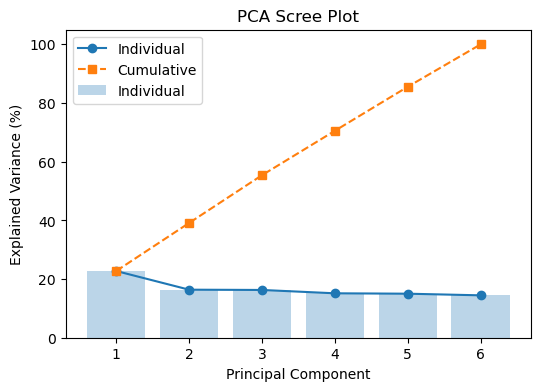

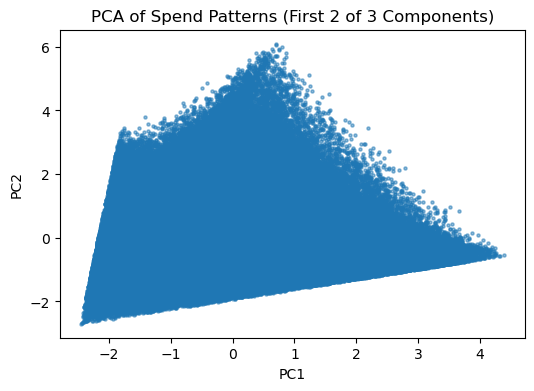

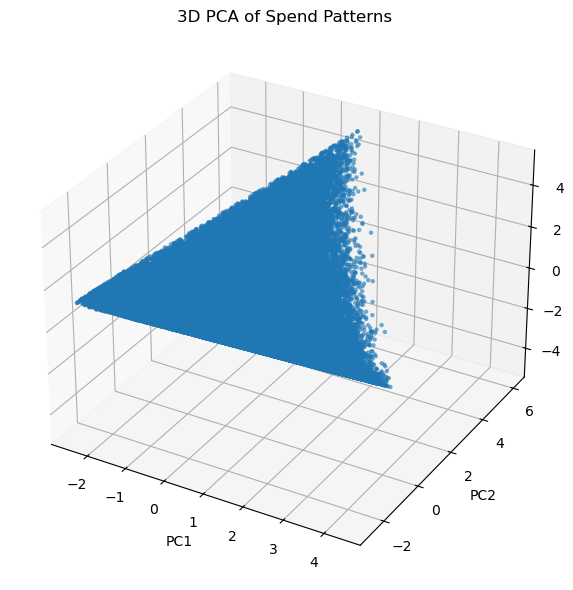

In [22]:
# Scree plot for PCA explained variance

pca = PCA(n_components=6)
pca.fit(X_scaled)
explained_var = pca.explained_variance_ratio_

plt.figure(figsize=(6,4))
plt.plot(range(1, len(explained_var)+1), explained_var*100, 'o-', label='Individual')
plt.bar(range(1, len(explained_var)+1), explained_var*100, alpha=0.3, label='Individual')
plt.plot(range(1, len(explained_var)+1), explained_var.cumsum()*100, 's--', label='Cumulative')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.title('PCA Scree Plot')
plt.legend()
plt.show()

# PCA with 3 components
pca3 = PCA(n_components=3).fit_transform(X_scaled)
plt.figure(figsize=(6,4))
plt.scatter(pca3[:,0], pca3[:,1], s=5, alpha=0.5)
plt.title("PCA of Spend Patterns (First 2 of 3 Components)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# 3D PCA scatter plot

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca3[:,0], pca3[:,1], pca3[:,2], s=5, alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA of Spend Patterns')
plt.tight_layout()
plt.show()



- Sampled silhouette & Davies–Bouldin to pick best k value at elbow


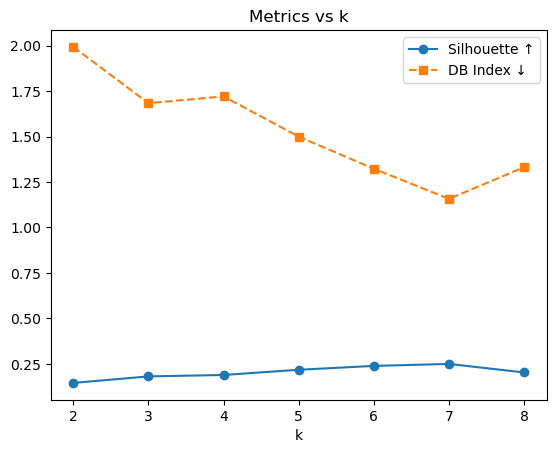

In [7]:
Ks = range(2,9)
sil, db = [], []
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled)
    labs = km.labels_
    sil.append(silhouette_score(X_scaled, labs,
                                sample_size=20000, random_state=42))
    db.append(davies_bouldin_score(X_scaled, labs))

plt.plot(Ks, sil, 'o-', label='Silhouette ↑')
plt.plot(Ks, db, 's--', label='DB Index ↓')
plt.title("Metrics vs k"); plt.xlabel("k"); plt.legend(); plt.show()

## Fit Final Clusters & Profile
- Choose best_k (7 from the graph above since DB index increases after 7)
- Assign cluster labels
- Compute each cluster’s mean spend_% by category


In [23]:
from sklearn.cluster import KMeans

best_k = 7   
km = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit(X_scaled)
spend_wide['cluster'] = km.labels_

segment_profile = (
    spend_wide
    .groupby('cluster')[features]
    .mean()
    .round(3)
)
print(segment_profile)


spend_cat  spend_ENTERTAINMENT_pct  spend_FUEL_pct  spend_GROCERIES_pct  \
cluster                                                                   
0                            0.337           0.146                0.117   
1                            0.092           0.164                0.318   
2                            0.066           0.114                0.091   
3                            0.091           0.366                0.123   
4                            0.081           0.141                0.111   
5                            0.070           0.122                0.098   
6                            0.087           0.156                0.126   

spend_cat  spend_OTHER_pct  spend_RETAIL_pct  spend_TRAVEL_pct  \
cluster                                                          
0                    0.183             0.159             0.037   
1                    0.194             0.178             0.037   
2                    0.555             0.126             0.0

### Principal component scatterplots grouped by cluster

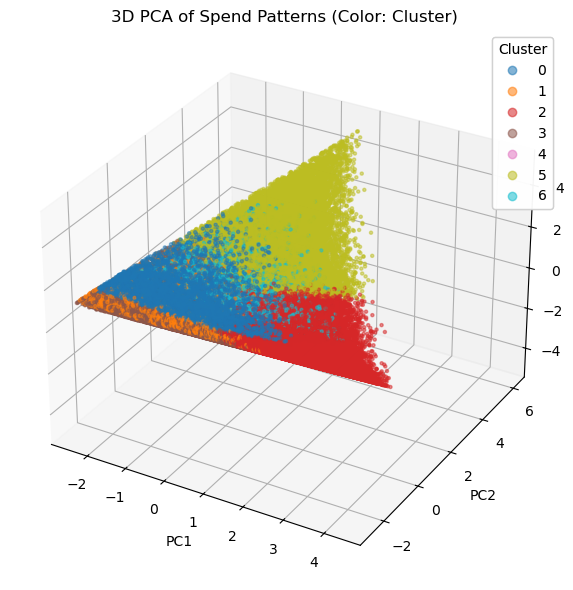

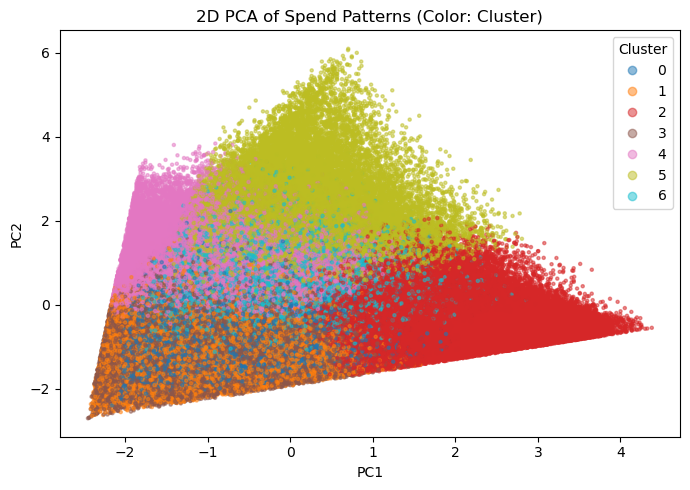

In [ ]:
# 3D PCA scatter plot with cluster color 
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    pca3[:,0], pca3[:,1], pca3[:,2],
    c=spend_wide['cluster'], cmap='tab10', s=5, alpha=0.5
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA of Spend Patterns (Color: Cluster)')
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster", loc="upper right")
ax.add_artist(legend1)
plt.tight_layout()
plt.show()

# 2D PCA scatter plot with cluster color 
plt.figure(figsize=(7,5))
scatter2d = plt.scatter(
    pca3[:,0], pca3[:,1],
    c=spend_wide['cluster'], cmap='tab10', s=5, alpha=0.5
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2D PCA of Spend Patterns (Color: Cluster)')
plt.legend(*scatter2d.legend_elements(), title="Cluster", loc="upper right")
plt.tight_layout()
plt.show()

Save the fitted model

In [ ]:
import pickle

with open('kmeans_model_creditcardsubtypeunsupervised.pkl', 'wb') as f:
    pickle.dump(km, f)

## Map Dominant Category → Card & Compute Affinity Score
- Find dominant_pct col per cluster
- Map that category to the specific card name
- Score each customer by their own pct in that category


In [24]:
# dominant_pct column per cluster
segment_profile['dominant_col'] = segment_profile.idxmax(axis=1)
segment_profile['dominant_cat'] = (
    segment_profile['dominant_col']
    .str.replace('spend_','')
    .str.replace('_pct','')
)

# product mapping
card_map = {
    'FUEL':         'Fuel Rewards Card',
    'TRAVEL':       'Travel Rewards Card',
    'GROCERIES':    'Grocery Cashback Card',
    'RETAIL':       'Retail Cashback Card',
    'ENTERTAINMENT':'Dining & Entertainment Card',
    'OTHER':        'General Purpose Card',
    'UNMAPPED':     'Standard Card'
}
segment_profile['recommended_card'] = segment_profile['dominant_cat'].map(card_map)

spend_wide['recommended_card'] = spend_wide['cluster'].map(segment_profile['recommended_card'])
dominant_map = segment_profile['dominant_cat'].to_dict()

# affinity score
spend_wide['recommendation_score'] = spend_wide.apply(
    lambda r: r[f"spend_{dominant_map[r['cluster']]}_pct"], axis=1
)

spend_wide.head(10)



spend_cat,customer_id,spend_ENTERTAINMENT,spend_FUEL,spend_GROCERIES,spend_OTHER,spend_RETAIL,spend_TRAVEL,spend_UNMAPPED,total_spend,spend_ENTERTAINMENT_pct,spend_FUEL_pct,spend_GROCERIES_pct,spend_OTHER_pct,spend_RETAIL_pct,spend_TRAVEL_pct,spend_UNMAPPED_pct,cluster,recommended_card,recommendation_score
0,15892,26.46,377.20,163.75,472.49,169.29,10.68,0.00,1219.87,0.021691,0.309213,0.134236,0.387328,0.138777,0.008755,0.000000,3,Fuel Rewards Card,0.309213
1,15895,33.42,182.40,314.21,219.51,134.19,34.90,0.00,918.63,0.036380,0.198557,0.342042,0.238954,0.146076,0.037991,0.000000,1,Grocery Cashback Card,0.342042
2,15896,165.04,36.91,33.37,595.66,184.10,0.00,0.00,1015.08,0.162588,0.036362,0.032874,0.586811,0.181365,0.000000,0.000000,2,General Purpose Card,0.586811
3,15897,151.13,37.41,155.60,140.00,287.69,21.72,0.00,793.55,0.190448,0.047143,0.196081,0.176422,0.362535,0.027371,0.000000,4,Retail Cashback Card,0.362535
4,15898,46.67,158.45,252.10,243.65,47.58,0.00,231.00,979.45,0.047649,0.161774,0.257389,0.248762,0.048578,0.000000,0.235847,6,Standard Card,0.235847
5,15901,107.86,271.46,179.23,34.57,244.03,41.34,0.00,878.49,0.122779,0.309008,0.204021,0.039352,0.277783,0.047058,0.000000,3,Fuel Rewards Card,0.309008
6,15902,176.89,139.99,309.41,153.65,87.52,18.01,0.00,885.47,0.199770,0.158097,0.349430,0.173524,0.098840,0.020339,0.000000,1,Grocery Cashback Card,0.349430
7,15903,159.35,130.91,276.98,0.00,65.06,320.00,339.07,1291.37,0.123396,0.101373,0.214485,0.000000,0.050381,0.247799,0.262566,6,Standard Card,0.262566
8,15911,58.55,221.35,91.22,497.79,191.65,19.15,0.00,1079.71,0.054228,0.205009,0.084486,0.461040,0.177501,0.017736,0.000000,2,General Purpose Card,0.461040
9,15920,17.55,86.85,19.07,468.57,195.70,0.00,0.00,787.74,0.022279,0.110252,0.024208,0.594828,0.248432,0.000000,0.000000,2,General Purpose Card,0.594828


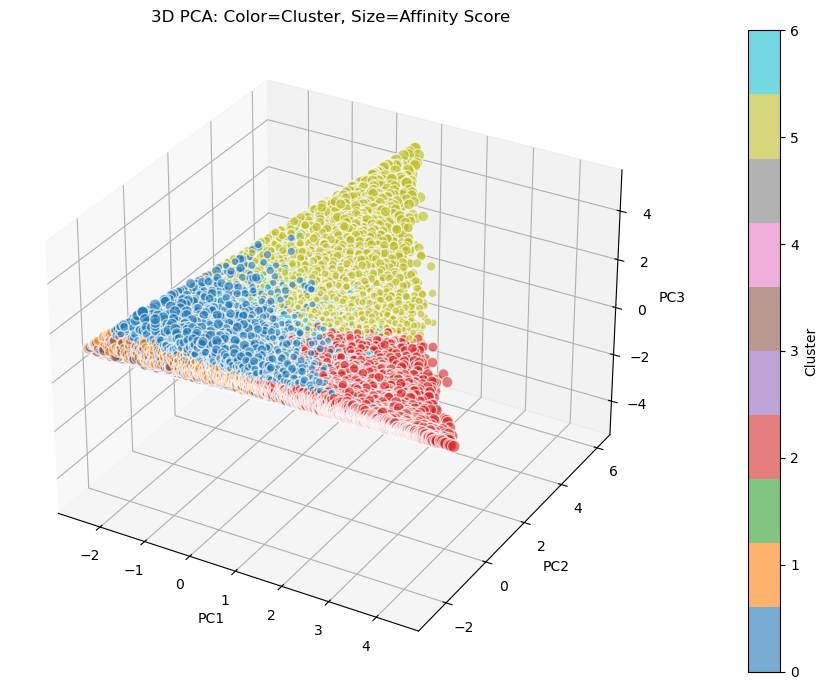

In [12]:
# 3D scatter: PC1, PC2, PC3, color by cluster, size by recommendation_score
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    pca3[:,0], pca3[:,1], pca3[:,2],
    c=spend_wide['cluster'], 
    s=80 * spend_wide['recommendation_score'],  # scale size
    cmap='tab10', alpha=0.6, edgecolor='w'
)
cb = plt.colorbar(sc, ax=ax, pad=0.1, label='Cluster')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA: Color=Cluster, Size=Affinity Score')
plt.tight_layout()
plt.show()

# 4D: Use plotly for interactive 3D+color+size
# import plotly.express as px

# fig = px.scatter_3d(
#     x=pca3[:,0], y=pca3[:,1], z=pca3[:,2],
#     color=spend_wide['recommended_card'],
#     size=spend_wide['recommendation_score'],
#     hover_name=spend_wide['customer_id'].astype(str),
#     title='4D PCA Visualization: 3D Position + Card Color + Affinity Size',
#     opacity=0.6
# )
# fig.update_traces(marker=dict(line=dict(width=0)))
# fig.show()

# # Export plotly figure to HTML for dashboard use
# fig.write_html("pca_4d_interactive.html")


## Apply 30% Affinity Cutoff
- Only keep offers for score ≥ 0.30, else “No Offer”


In [13]:
threshold = 0.30
spend_wide['final_offer'] = spend_wide.apply(
    lambda r: r['recommended_card'] if r['recommendation_score'] >= threshold
              else 'No Targeted Offer',
    axis=1
)
spend_wide[['customer_id','cluster','recommendation_score','final_offer']].head(10)


spend_cat,customer_id,cluster,recommendation_score,final_offer
0,15892,3,0.309213,Fuel Rewards Card
1,15895,1,0.342042,Grocery Cashback Card
2,15896,2,0.586811,General Purpose Card
3,15897,4,0.362535,Retail Cashback Card
4,15898,6,0.235847,No Targeted Offer
5,15901,3,0.309008,Fuel Rewards Card
6,15902,1,0.349430,Grocery Cashback Card
7,15903,6,0.262566,No Targeted Offer
8,15911,2,0.461040,General Purpose Card
9,15920,2,0.594828,General Purpose Card


### Donut chart


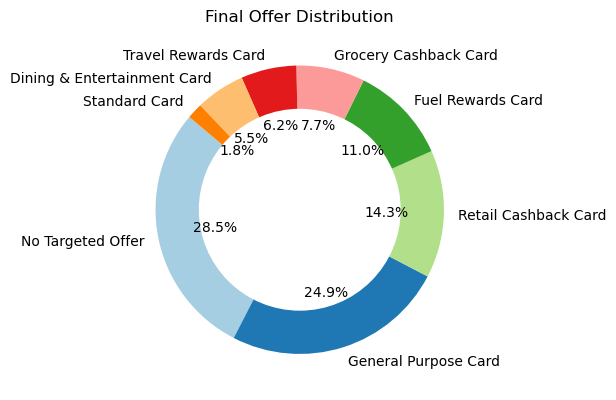

In [14]:
offer_counts = spend_wide['final_offer'].value_counts()
plt.figure(figsize=(6,6))
wedges, texts, autotexts = plt.pie(offer_counts, labels=offer_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Final Offer Distribution')
plt.tight_layout()
plt.show()

## Interactive chart


In [ ]:
offer_counts = spend_wide['final_offer'].value_counts()
labels = offer_counts.index.tolist()
values = offer_counts.values.tolist()

# Map offer to customer IDs
offer_to_customers = spend_wide.groupby('final_offer')['customer_id'].apply(list).to_dict()

# Create Plotly donut chart
fig = go.FigureWidget(
    data=[go.Pie(
        labels=labels,
        values=values,
        hole=0.6,
        hoverinfo='label+percent+value',
        marker=dict(colors=px.colors.qualitative.Pastel)
    )]
)
fig.update_layout(title_text='Final Offer Distribution (Interactive Donut)')

# Output area for customer list
import ipywidgets as widgets
output = widgets.Output()

# The event jhandler for onClick 
def on_click(trace, points, state):
    with output:
        clear_output()
        if points.point_inds:
            idx = points.point_inds[0]
            offer = labels[idx]
            customers = offer_to_customers[offer]
            print(f"Customers in '{offer}' ({len(customers)}):")
            display(pd.DataFrame({'customer_id': customers}))

fig.data[0].on_click(on_click)

display(fig, output)

FigureWidget({
    'data': [{'hole': 0.6,
              'hoverinfo': 'label+percent+value',
              'labels': [No Targeted Offer, General Purpose Card, Retail Cashback
                         Card, Fuel Rewards Card, Grocery Cashback Card, Travel
                         Rewards Card, Dining & Entertainment Card, Standard Card],
              'marker': {'colors': [rgb(102, 197, 204), rgb(246, 207, 113),
                                    rgb(248, 156, 116), rgb(220, 176, 242),
                                    rgb(135, 197, 95), rgb(158, 185, 243), rgb(254,
                                    136, 177), rgb(201, 219, 116), rgb(139, 224,
                                    164), rgb(180, 151, 231), rgb(179, 179, 179)]},
              'type': 'pie',
              'uid': '6f1fab9d-6c81-4c26-98c3-15da89b0351e',
              'values': [100555, 87762, 50429, 38877, 27055, 21880, 19488, 6214]}],
    'layout': {'template': '...', 'title': {'text': 'Final Offer Distribution (Interact

Output()

## Treemap

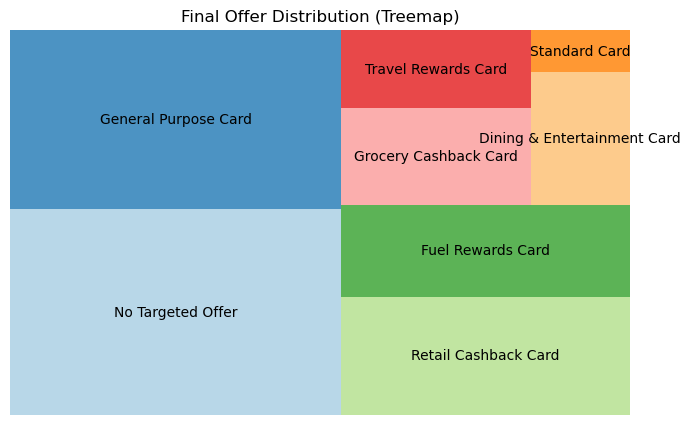

In [18]:
import squarify
offer_counts = spend_wide['final_offer'].value_counts()
plt.figure(figsize=(8,5))
squarify.plot(sizes=offer_counts.values, label=offer_counts.index, alpha=0.8, color=plt.cm.Paired.colors)
plt.title('Final Offer Distribution (Treemap)')
plt.axis('off')
plt.show()

# Attach Sample Card-Product Metadata 


In [ ]:
card_metadata = {
    'Fuel Rewards Card':            {'Reward Rate': '3% back on fuel',       'Annual Fee': '$0',   'Intro APR': '0% for 12 months'},
    'Travel Rewards Card':          {'Reward Rate': '2x points on travel',   'Annual Fee': '$95',  'Intro APR': '0% for 9 months'},
    'Grocery Cashback Card':        {'Reward Rate': '4% back on groceries',  'Annual Fee': '$0',   'Intro APR': '0% for 15 months'},
    'Retail Cashback Card':         {'Reward Rate': '5% back on retail',     'Annual Fee': '$49',  'Intro APR': '0% for 12 months'},
    'Dining & Entertainment Card':  {'Reward Rate': '3x points on dining',   'Annual Fee': '$29',   'Intro APR': 'N/A'},
    'General Purpose Card':         {'Reward Rate': '1.5% on all purchases', 'Annual Fee': '$0',   'Intro APR': '0% for 12 months'},
    'Standard Card':                {'Reward Rate': "0.5% back on all",        'Annual Fee': '$0',   'Intro APR': 'N/A'}
}

meta_df = pd.DataFrame.from_dict(card_metadata, orient='index')\
             .reset_index()\
             .rename(columns={'index':'recommended_card'})

# Merging card metadata back 
final = spend_wide.merge(meta_df, on='recommended_card', how='left')

cols = [
    'customer_id', 'cluster', 'recommendation_score',
    'recommended_card', 'Reward Rate', 'Annual Fee', 'Intro APR'
]
final[cols].head(10)


,customer_id,cluster,recommendation_score,recommended_card,Reward Rate,Annual Fee,Intro APR
0,15892,3,0.309213,Fuel Rewards Card,3% back on fuel,$0,0% for 12 months
1,15895,1,0.342042,Grocery Cashback Card,4% back on groceries,$0,0% for 15 months
2,15896,2,0.586811,General Purpose Card,1.5% on all purchases,$0,0% for 12 months
3,15897,4,0.362535,Retail Cashback Card,5% back on retail,$49,0% for 12 months
4,15898,6,0.235847,Standard Card,0.5% back on all,$0,N/A
5,15901,3,0.309008,Fuel Rewards Card,3% back on fuel,$0,0% for 12 months
6,15902,1,0.349430,Grocery Cashback Card,4% back on groceries,$0,0% for 15 months
7,15903,6,0.262566,Standard Card,0.5% back on all,$0,N/A
8,15911,2,0.461040,General Purpose Card,1.5% on all purchases,$0,0% for 12 months
9,15920,2,0.594828,General Purpose Card,1.5% on all purchases,$0,0% for 12 months
